# Predicting Student Success Using Virtual Learning Environment Interaction Statistics

In [195]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import load_OU_data, CourseScaler, plot_confusion, score_grid, \
smotecourses, process_courses, course_cross_validate, Course_GridSearchCV, \
registration_correlations, dist_by_course

from dython.nominal import associations

import pickle

import warnings

warnings.filterwarnings("ignore")
sns.set_style('white')
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Problem

![empty computer](../figures/goran-ivos-empty-computer-unsplash.jpg)

Online learning has been a growing and maturing industry for years now, and in a way the internet has always been about learning.  [Khan Academy](https://www.khanacademy.org/) is, to me, a quintessential step in self-driven learning and massive open online courses (MOOCs) like [Coursera](https://www.coursera.org/) create an even more structured approach to online, self-drive learning.  I took my first online course on coding fundamentals from [edX](https://www.edx.org/) in 2013.

While these are an amazing resource, they also have a high dropout and failure rate.  Many of us, accustomed to the accountability features in traditional face-to-face learning, struggle with the open-ness of these systems and the lack of a person keeping us accountable.  It can be easy to fall through the cracks and fade away.

I set out to find ways to use data to help online courses improve student success by identifying students who are in danger of failing or withdrawing early.  My theory is that students in need of special intervention to improve their chances of success can be identified by the way they interact with the online learning system itself.  

This project seeks to create a model of student interactions with self-paced learning modules that can predict student outcomes after the first half of the course.  My goal is to make this model generalizable by removing correlations with specific courses and instead capturing the underlying functions that can predict the success of students in any self-paced online learning environment.  I realize this is a lofty goal, but I believe it is possible to do to some extent. I believe that many students who are struggling will exhibit particular patterns of behavior in how they interact with the learning environment.

# The Data
I used a dataset from [Open University](http://www.openuniversity.edu/) based out of Great Britain.  They are an entirely online university offering accredited degrees to distance learners.  They released anonymized data from seven courses, three from the social sciences and four STEM courses, from the 2013 and 2014.  These courses are repeated twice per year and each repetitio is call a 'presentation'. Not all presentations of each course are included in the dataset.  To learn more about how the data was selected and anonymised, please visit this [US National Institute of Health](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5704676/) site that holds the data for scientific inquiry (like mine!)

This dataset contains regional, demographic, and personal data about students, but I was only interested in data about how they interacted with the learning environment.  In the StudentVle.csv file available in the [anonymiseData.zip](content/anonymisedData.zip) file they university provided information about each activity that each student interacted with, including the date and number of clicks on that activity.  

**I used this data to compile 6 statistical features:**

*Activity Statistics*
1. Number of total clicks during the presentation of the course.
2. Number of total activities completed
3. Number of days worked

It was the last statistic that I felt would be uniquely predictive.  I spent 14 years teaching students and one thing I learned from research and experience is that spreading learning out over more days, rather than cramming more learning on fewer days, helps with persistence and with learning retention.  It helps with persistence because it causes the student to form a habit of learning.  We are creatures of habit.  Cramming a lot of learning into fewer days is also more exhausting and less pleasant, creating a sense of aversion to the act.  Frequent reinforcement of learning also serves to reinforce neuronal axons that are the physical manifestation of learning.  I'll show what I found on this later on in this notebook.

The next statistics I pulled to use to train my model were the actions on assessments.

*Assessment Statistics*
1. Average assessment score
2. Number of assessments completed.

The first was an obvious choice, and the second is meaningful because these courses were in part self-paced.  I found that doing more assessments earlier was correlated to greater success, as you will see in the data exploration section later.

*Course Repetition*

The final statistic I took was the number of times the student had repeated the same course.  To be completely honest this is not data directly from interactions, and is in fact a sort of meta-data.  However it should be available in any learning environement that tracks student histories across courses.

#  Data Preparation
I took several steps in order to prepare the data for exploration and modeling.

1. I merged the 7 tables in the provided zip file.
2. I cleaned the data of rows with values missing in important columns, or suspicious values such as student withdrawing before they register or withdrawing after the end of the course.
3. I extracted statistics on the virtual learning environment interaction data as new features, see above.
4. I extracted statistics on assessments as new features, see above.
5. I enabled the data preparation function to filter a prediction window that would limit the data to registration records for students whom completed the course or withdrew after the prediction window and limisted the extracted statistics to those assessment and interaction records occuring previous to the the end of the prediction window.  

# Data Exploration
Let's take a look at the shape and general statistics of the data.
We will drop the columns our model will not use.  They were useful to explore some correlations between demographics and outcomes, but are not relevant to our actual modeling.  If you want to see more about what I found in that exploration, please see my [EDA notebook](../notebooks/OU_eda.ipynb)

Here I will focus on correlations within the activity and assessment statistics that I will be using for modeling.  

The data below represent the entire dataset, not just the prediction window I will be using for modeling.

In [196]:
df = load_OU_data(prediction_window = None)
df.drop(columns = ['id_student','code_presentation','region','highest_education', \
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration'], inplace = True)
if 'date_unregistration' in df.columns:
    df.drop(columns = ['date_unregistration'], inplace = True)
df.head()

,code_module,num_of_prev_attempts,final_result,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
0,AAA,0,Pass,40.0,196.0,934.0,5.0,82.0
1,AAA,0,Pass,80.0,430.0,1435.0,5.0,66.4
2,AAA,0,Withdrawn,12.0,76.0,281.0,0.0,0.0
3,AAA,0,Pass,123.0,663.0,2158.0,5.0,76.0
4,AAA,0,Pass,70.0,352.0,1034.0,5.0,54.4


In [197]:
df.describe()

,num_of_prev_attempts,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
count,28430.000000,28430.000000,28430.000000,28430.000000,28430.000000,28430.000000
mean,0.161977,60.103904,352.992332,1312.640943,5.837883,63.301888
std,0.476656,53.703165,374.433547,1711.727896,4.166949,28.686925
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,17.000000,87.000000,240.000000,2.000000,56.000000
50%,0.000000,45.000000,232.000000,704.000000,5.000000,73.000000
75%,0.000000,90.000000,492.000000,1704.000000,9.000000,83.142857
max,6.000000,286.000000,3078.000000,24139.000000,14.000000,100.000000


We see here some very large standard deviations in some of these statistics.  Notice that `total_clicks` ranges from 1 to 24139 and activities engaged ranges from 1 to 3078.  Let's further explore these distributions

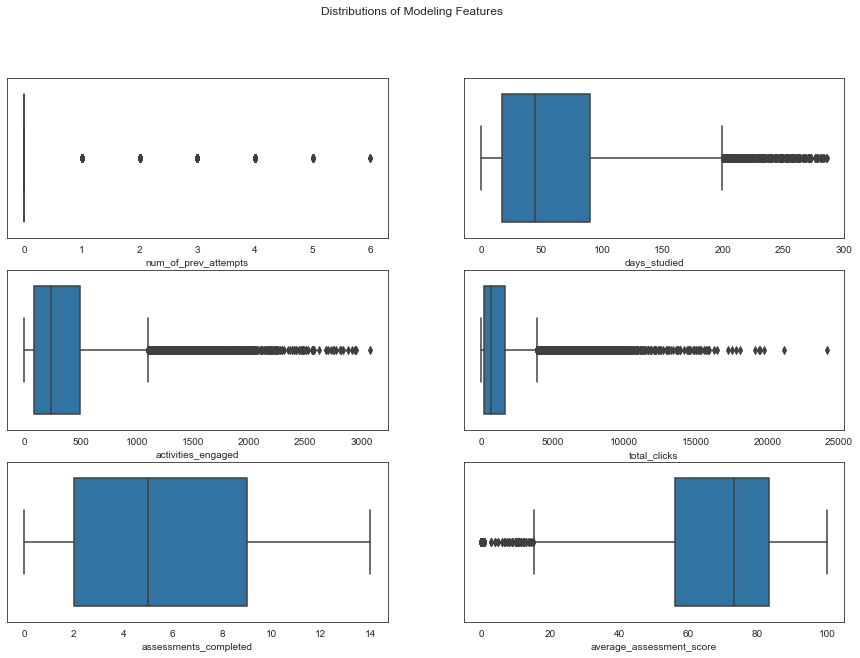

In [198]:
fig, axes = plt.subplots(3,2, figsize = (15,10))
columns = [ 'num_of_prev_attempts', 'days_studied',
       'activities_engaged', 'total_clicks', 'assessments_completed',
       'average_assessment_score']
for i, ax in enumerate(axes.ravel()):
    
    sns.boxplot(df[columns[i]], ax=ax)
plt.suptitle('Distributions of Modeling Features')
plt.show()

There are definitely some outliers, students who seemed to click an order of magnitude more than the average.  We also see few students who repeated the course.  The distribution of `activities_engaged` makes me wonder how many activities were available in the courses and whether my data includes some repeats in the activity engagements.  Based on these boxplots, there are obviously outliers, but there seem to be a lot of them in most cases.  I'm actually not going to remove any of these.  That may or may not be the right decision and in future iterations I may try doing so after all.

## Correlations:
I am indebted to Shaked Zychlinsk and his [dython module](https://github.com/shakedzy/dython) for the below correlation matrix function, which uses it internally.  Please refer to the documentation of the `dython.nominal.associations` function to see how it dynamically chooses the right kind of correlation for each box, depending on whether its categorical/categorical, nominal/categorical, or nominal/nominal.

One note, registration_correlations are turning `final_results` into a nominal variable with higher numbers being better outcomes.  This helps us see not how much another variable affects it, but how it affects it.

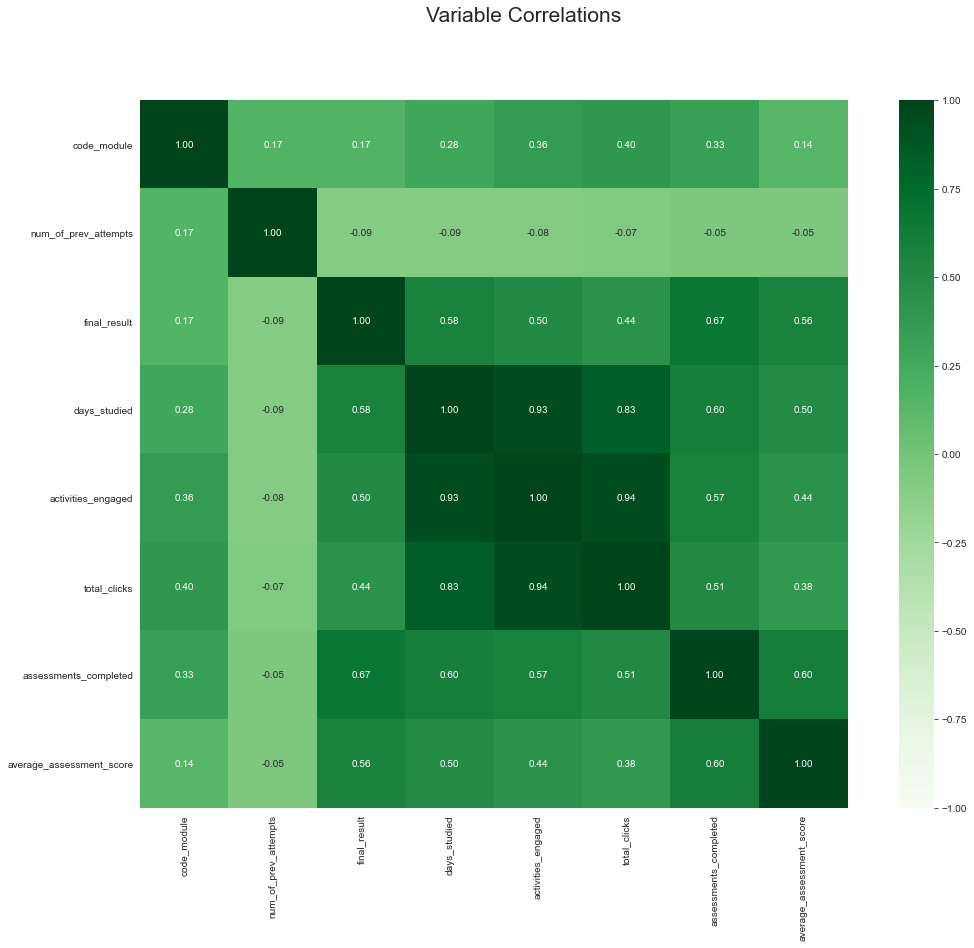

In [199]:
registration_correlations(df, cmap = 'Greens', save_path = '../figures/coursecorr.png')

### The good news and the bad news
**First the good**

1. `days_studied` has a .50 correlation ratio with the final result!  In fact all of our activity and assessment statistics have strong correlations with the final result.  `num_of_prev_attempts` is also correlated, negatively.  While the vast majority of students only seem to have taken the course once (as far as we know from the data we have), there is a correlation here.

2. `days_studied` is only topped by number of assessments completed for most correlated, which feels like a win for my hypothesis above.  It's even more highly correlated than assessment scores!

3. `total_clicks` is not as highly correlated as the others.  This is interesting.

**Now the bad**

1. Our activity stats are al very highly correlated to each other, and this stands to reason.  The more days you study, the more activities you engage.  The more activities you engage, the more times you click.  `assessments_completed` and `average_assessment_score` are also correlated, but not as strongly as one might thing.  This high correlation between features would be a problem if we were doing inferential modeling, such as OLS, but it's fine for predictive modeling.  If we want to do inferences we would probably have to just pick one of those (`days_studied` would be my candidate).

2. The activity stats and assessment stats are correlated to `code_module`.  This leads me to believe that different courses have different numbers of assessments and different numbers of essential activities.  This also stands to reason, why would all the courses be the same?  Since I want to extend this model to new courses in new learning systems this will become even more important.  This bias by course will become a hidden variable that will disrupt future predictions on new courses, and also is outside the scope of what we are trying to accompish: predicting by activity.  We need away way around this.

3. `final_result` is also correlated to `code_module`, which presents a problem in itself.  This tells me that different courses have different success rates, which of course is also obvious if we think about it.  The correlation to our target variable is a separate problem from the correlation to our predictor variables.

# Prediction Window
A key element of my model is that it is meant to be an early warning system.  It flags students for intervention before the end of the course in order to change their trajectory.  The prediction window is easy to change on all of these notebooks as it's a single argument in the data loading function.  There is a trade-off though.  A wider window not only gives less time for a student to catch up or change their habits, students also continually withdraw from the course.  The longer we wait, the more students we lose.  On the other hand, more data mean better predictions.  The more the model has seen of the students' behavior, the more accurate it can be.  Let's take a look at when students leave the programs:

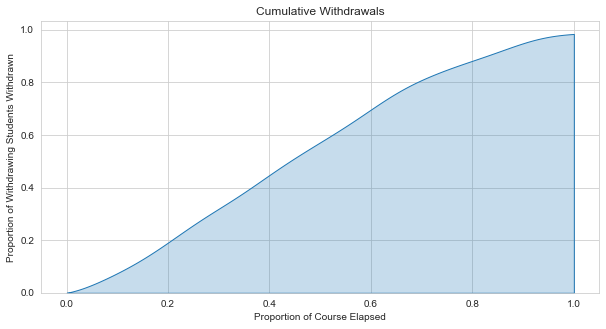

In [200]:
sns.set_style('whitegrid')
# full_data = load_OU_data(prediction_window=None)
withdrawals = full_data[full_data['final_result'] == 'Withdrawn']
withdraw_time = withdrawals['date_unregistration']/withdrawals['module_presentation_length']

fig, ax = plt.subplots(1,1, figsize = (10,5))
sns.kdeplot(data=full_data[full_data.final_result == 'Withdrawn'], ax = ax,
            x=withdraw_time, clip = (0,1), fill=True, 
            cumulative = True).set_title('Cumulative Withdrawals')
ax.set_ylabel('Proportion of Withdrawing Students Withdrawn')
ax.set_xlabel('Proportion of Course Elapsed')
plt.savefig('../figures/course_withdrawal_rate.png')
plt.show()

By the halfway point of the course, just under 60% of the students who will withdraw already have. A prediction window of .5 doesn't give us a ton of data, but it is quite late in the course in terms of trying to retain withdrawing students.  This notebook, or the [model development notebook](../notebooks/shallow_modeling.ipynb) can be run with different prediction windows by changing the `prediction_window` variable in `load_OU_data()` function.

# Preprocessing
I told you some about preparing the data, but there is more to do to overcome the problems mentioned above.

1. We will limit the data to what makes sense for our prediction window, or the points in the course we want to make our predictions on.  For one, we won't try to predict the outcomes of students who have already withdrawn.  We also won't use any data that we would not yet have by that point in the course.

2. Our data target classes are 'Distinction', 'Pass', 'Fail', and 'Withdrawn'.  However, our predictor only predicts whether a student needs intervention or not.  Those passing or passing with distinction do not need interventions, while those failing or withdrawing do.  We will combine the first two into a new class 'No Intervention' and the second two into 'Needs Intervention'.  This makes our target binary, easier to predict and easier to evaluate.

3. We will scale all the data course by course.  The CourseScaler class will fit on each individual course, as indexed by the 'code_module' variable.  It will take the mean and standard deviation for each feature for each course from the training data and use these means and standard deviations to scale each feature for each individual course ((feature-mean)/standard deviation) for both the training and the testing data.  This will remove the correlations between `code_module` and the activity and assessment statistics.

4. We will use the smotecourses() function to apply [imblearn.over_sampling.SMOTE](https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.SMOTE.html) to the training data to create synthetic data within the minority class to balance the classes.  Each course in the training set will then have equal number of students needing intervention and not needing interventions (as far as the model knows for training purposes).  This will remove the correlation between `code_module` and `final_result`.  

5. Once those are done, we can drop the `code_module` column, because we don't want our model considering that in its predictions.

Let's take a look at how these steps effect our correlation matrix.

## Scaling

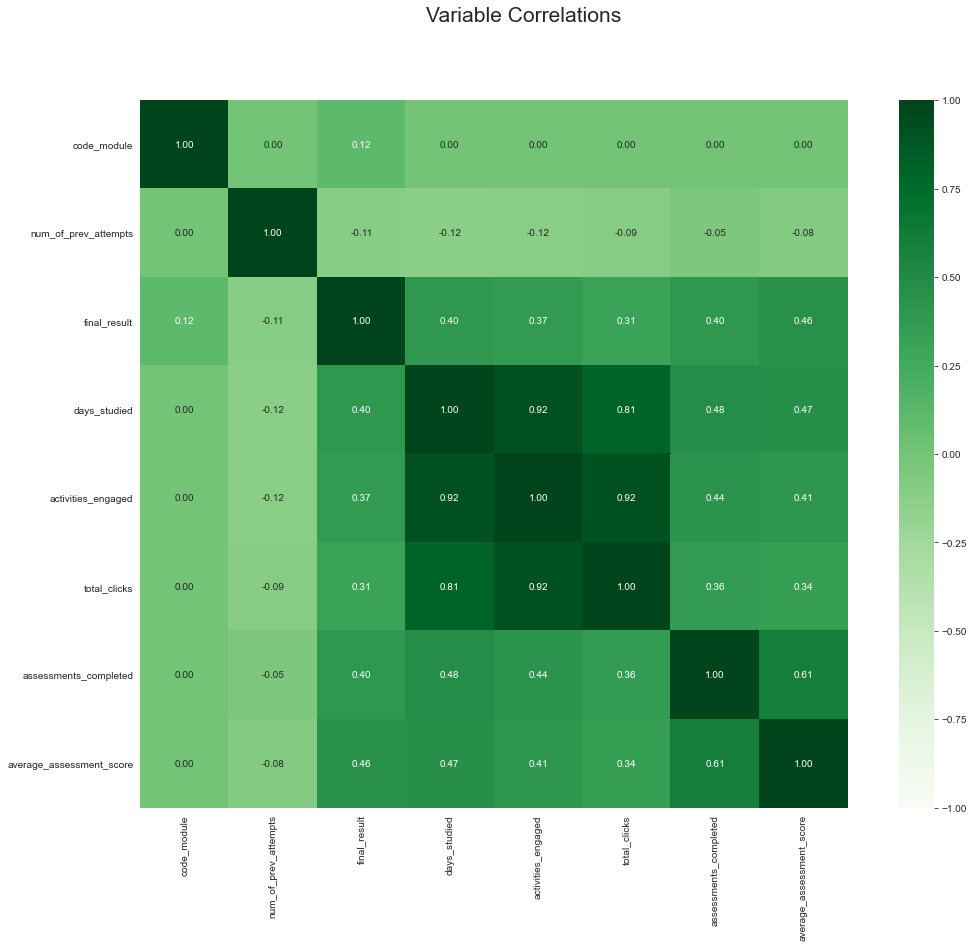

In [222]:
#Setting prediction_window to .5 loads data up to the halfway point of the shortest course present
half_df = load_OU_data(prediction_window=.5)
half_df.drop(columns = ['id_student','code_presentation','region','highest_education', \
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration'], inplace = True)

#Scale the variables, but keep `code_module` for comparing
cs = CourseScaler(drop_course=False)
scaled_half_df = cs.fit_transform(half_df)

#create the new correlation matrix
registration_correlations(scaled_half_df, cmap = 'Greens', save_path = '../figures/scaledcoursecorr.png')

By scaling the data by course we have removed the correlations along the top row for most variables.  the only thing left is the target variable, `final_result`.  We can take care of that by balancing the classes in each course.

## SMOTE-ing

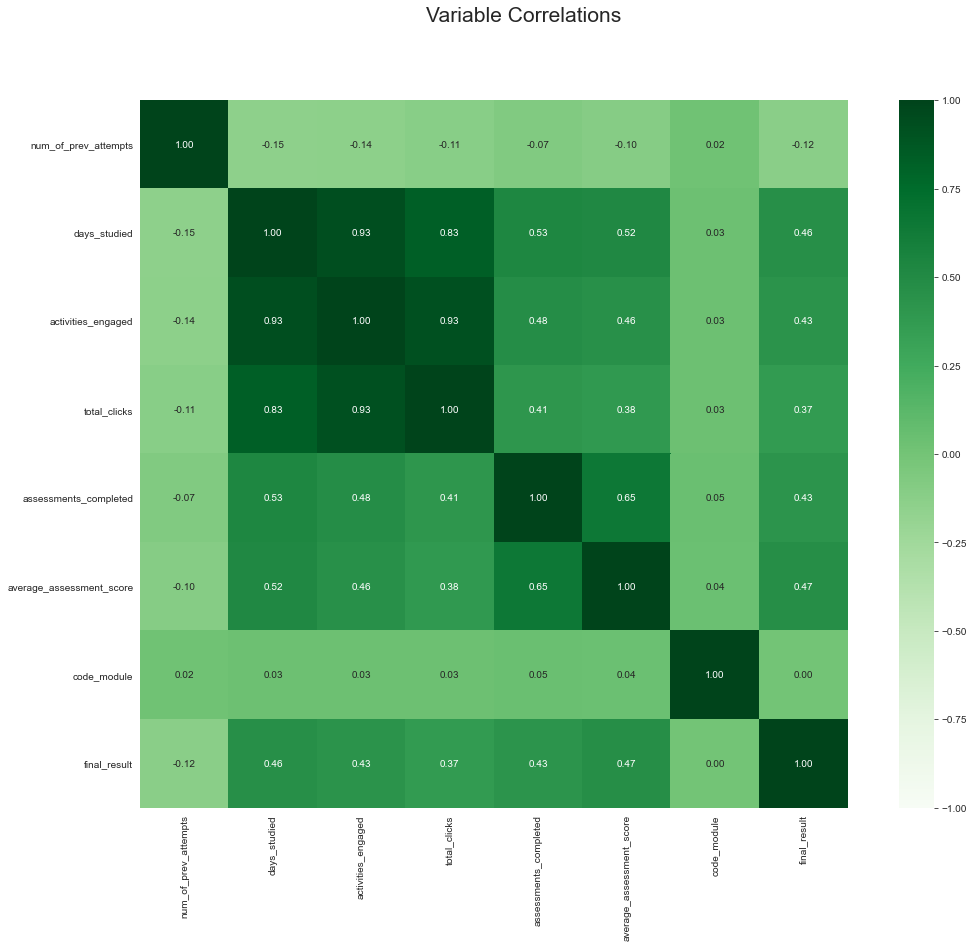

In [223]:
demo_X = scaled_half_df.drop('final_result', axis=1)
demo_y = scaled_half_df['final_result']

smoted_X, smoted_y = smotecourses(demo_X, demo_y, drop_course=False)
smoted_X['final_result'] = smoted_y
registration_correlations(smoted_X, cmap='Greens', save_path = '../figures/scaled_smoted_coursecorrs.png')

The smoting process added a small amount of residual correlation between the `code_module` and some of the features, but nothing significant.  There is now no correlation between the specific courses and our target variable, `final_result`

# Modeling
The heavy lifting here was in the data preparation and preprocessing.  We will try a few different models, a logistic regression for a baseline FSM, and then some tree based models, a decision tree, a random forest, and an eXtreme Gradient Boost model (because Kagglers love them!)

I used a custom Course_GridSearchCV class to do a grid based hyperparameter search to help me set good hyperparameters for each of these.  This was needed because my scaler and smoter each need the `code_module` feature in order to do their work, but need to remove it before modeling.  This was not possible to do with the sklearn or imblearn pipelines or with with the cross validation functions they offer.  So, I wrote my own.  

I won't show the whole grid search process here, but if you'd like to see how I did it, please visit my [model development notebook](../notebooks/shallow_modeling.ipynb). You can also find a brief discussion of how each model works and links to more information there.

### Data Preparation
I will divide our dataset into features, `X` and labels, `y`.  Then I will collapse the 4 labels into 2 bins, as I discussed before and divide them into training and testing sets.

For all of these models we will use course_cross_validate, which fits a CourseScaler on the training data, and transforms both training and testing data for each fold.  Then it will use smotecourses() smote the training data for each fold and report the scores for each fold.  This prevents data leakage into our testing folds from either process and combats overfitting.

In [224]:
X = half_df.drop('final_result', axis=1)
y = half_df['final_result']

y = np.array(['No Intervention' if w in ['Pass','Distinction'] \
              else 'Needs Intervention' for w in y])

cv = KFold(shuffle=True, random_state=111)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 111, test_size=.2)

#the cross validator processes data as it's validating, but we want a set for final evaluation, too.
X_train_transformed, y_train_transformed, X_test_transformed = process_courses(X_train, y_train, X_test)

## Logistic Regression

Model Hyperparamters:
LogisticRegression(l1_ratio=0.7, penalty='l1', random_state=111,
                   solver='liblinear')
Validation scores across folds are:
[0.7680020947892119, 0.7611940298507462, 0.7619172341540074, 0.7663698271346254, 0.7723939235201677]
Mean validation scores is:
0.7659754218897517
Evaluation on hold-out set.
                    precision    recall  f1-score   support

Needs Intervention       0.68      0.72      0.70      1804
   No Intervention       0.83      0.79      0.81      2969

          accuracy                           0.77      4773
         macro avg       0.75      0.76      0.76      4773
      weighted avg       0.77      0.77      0.77      4773



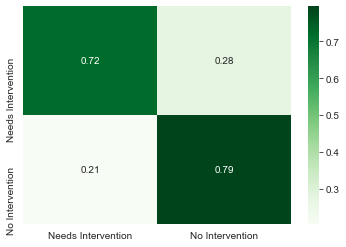

In [225]:

model = pickle.load(open('../models/LRmodel2.pkl','rb'))
print('Model Hyperparamters:')
print(model)
scores = course_cross_validate(model, X_train, y_train, cv=cv, scoring='accuracy', random_state=111)
print('Validation scores across folds are:')
print(scores)
print('Mean validation scores is:')
print(np.mean(scores))
model.fit(X_train_transformed, y_train_transformed)
y_pred = model.predict(X_test_transformed)
print('Evaluation on hold-out set.')
print(classification_report(y_test, y_pred))
plot_confusion(y_test, y_pred)

The mean cross validated score is similar to the score on the hold out set, and the confusion matrix is pretty balanced.  This is a great start for our model.  It successfully classifies about 75% of students.

## Decision Tree
I decided to try a decision tree next because I though the data might not be linearly correlated enough for a logistic regression.  Perhaps a less linear approach would give us a better accuracy.

Model Hyperparamters:
DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=5,
                       min_samples_split=0.5, random_state=111,
                       splitter='random')
Validation scores across folds are:
[0.7282010997643362, 0.7389368944749934, 0.7556312205343112, 0.7569408067050812, 0.7616553169198533]
Mean validation scores is:
0.7482730676797151
Evaluation on hold-out set.
                    precision    recall  f1-score   support

Needs Intervention       0.59      0.75      0.66      1804
   No Intervention       0.82      0.68      0.74      2969

          accuracy                           0.71      4773
         macro avg       0.70      0.71      0.70      4773
      weighted avg       0.73      0.71      0.71      4773



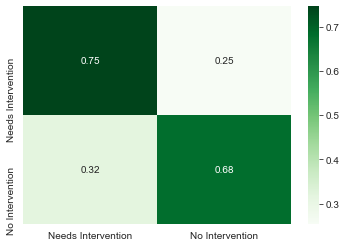

In [226]:
model = pickle.load(open('../models/DTmodel2.pkl','rb'))
print('Model Hyperparamters:')
print(model)
scores = course_cross_validate(model, X_train, y_train, cv=cv, scoring='accuracy', random_state=111)
print('Validation scores across folds are:')
print(scores)
print('Mean validation scores is:')
print(np.mean(scores))
model.fit(X_train_transformed, y_train_transformed)
y_pred = model.predict(X_test_transformed)
print('Evaluation on hold-out set.')
print(classification_report(y_test, y_pred))
plot_confusion(y_test, y_pred)

While the decision tree correctly classifies the same number of passing students as the logistic regression model, it struggles more to identify the students in need of interventions.  I would have though it would do better on this data.  In my model development the decision tree slightly outperformed the logistic regression.  The difference was only 1-2% one way or another.  Neither is clearly superior to the other.

# Random Forest
If one decision tree doesn't work, lets try 150 working together!  Maybe they can better classify these students with bootstrap aggregation, or bagging.

Model Hyperparamters:
RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_split=5,
                       n_estimators=150, n_jobs=-1, random_state=111)
Validation scores across folds are:
[0.7748101597276774, 0.7708824299554857, 0.7784180199057098, 0.7789418543740179, 0.78627553693033]
Mean validation scores is:
0.7778656001786441
Evaluation on hold-out set.
                    precision    recall  f1-score   support

Needs Intervention       0.70      0.71      0.70      1804
   No Intervention       0.82      0.81      0.82      2969

          accuracy                           0.77      4773
         macro avg       0.76      0.76      0.76      4773
      weighted avg       0.78      0.77      0.77      4773



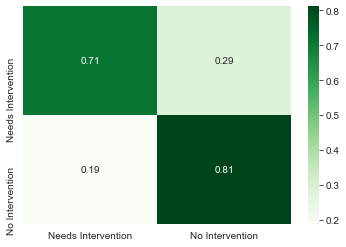

In [227]:
model = pickle.load(open('../models/RFmodel2.pkl','rb'))
print('Model Hyperparamters:')
print(model)
scores = course_cross_validate(model, X_train, y_train, cv=cv, scoring='accuracy', random_state=111)
print('Validation scores across folds are:')
print(scores)
print('Mean validation scores is:')
print(np.mean(scores))
model.fit(X_train_transformed, y_train_transformed)
y_pred = model.predict(X_test_transformed)
print('Evaluation on hold-out set.')
print(classification_report(y_test, y_pred))
plot_confusion(y_test, y_pred)

All of these models so far are performing at 73-74% on the hold-out data, and performance across folds in the cross-validation is pretty even.  This tells me that we are not suffering from overfitting, but it would great to find a way to reduce the bias, or the general accuracy of the model.

# eXtreme Gradient Boosting
We tried one tree, we tried a forest of trees, let's try stacking trees on top top of each and letting each one boost the one before it.  This is a trendy model these days, lets see how it performs for us!

Model Hyperparamters:
XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='logloss',
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=2, random_state=111, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=None)
Validation scores across folds are:
[0.7858078030898141, 0.7873788949986907, 0.785751702462022, 0.7912519643792562, 0.7980618124672604]
Mean validation scores is:
0.7896504354794087
Evaluation on hold-out set.
                    precision    recall  f1-score   support

Needs Intervention       0.71      0.75      0.73      1804
   No Intervention       0.85

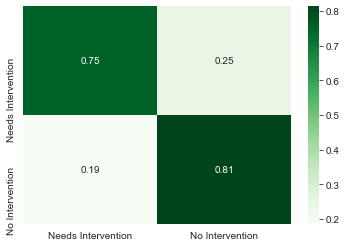

In [228]:
model = pickle.load(open('../models/XGBmodel4.pkl','rb'))
print('Model Hyperparamters:')
print(model)
scores = course_cross_validate(model, X_train, y_train, cv=cv, scoring='accuracy', random_state=111)
print('Validation scores across folds are:')
print(scores)
print('Mean validation scores is:')
print(np.mean(scores))
model.fit(X_train_transformed, y_train_transformed)
y_pred = model.predict(X_test_transformed)
print('Evaluation on hold-out set.')
print(classification_report(y_test, y_pred))
plot_confusion(y_test, y_pred, save_path = '../figures/XGBoost79confmatrix.png')

XGBoost proves itself again!  It performs better on both classes and achieves 79% overall accuracy on the hold-out dataset.  The validation folds are all in line with the final results, showing us we have avoided overfitting problems.  We have a winner!

# Final model: XGBoost!

# Summary
I used data about virtual learning environment interactions of ~22k students taking 7 different courses to create a model that would predict, with 79% accuracy, whether they would pass the course they were taking.  I used scaling and SMOTE-ing to normalize the data across different courses with different difficulties and success rates and created a generalizable model that should be accurate for other learning environments.  I limited the data I used to the first half of the course to simulate the model flagging students for intervention before they withdrew or failed the course and with enough time to change their trajectory.

# Next Steps:
1. There are many more model types I can try with this data.  I could use an SVM to attempt to draw a hyperplane to divide my datapoints into the two classes, or I could use deep learning networks to take a more abstract approach to solving the problem.  

2. I could try larger prediction window and focus more on failing students than withdrawing ones, or a smaller prediction window.

3. I would love to try this model and preprocessing routine out on new datasets to see how well it generalizes.

4. I could try removing some of the outliers.

5. Finally, I could dig deeper into the errors my model is making to see if I can see what trips it up. what are the commonalities among students that are misclassified